In [47]:
%matplotlib inline

import os
import sys
import pylab
import random
from random import randint, uniform
from skimage.util import crop
from skimage import transform
import numpy as np
import pandas as pd
import cPickle as pkl
from lasagne import layers
from bs4 import BeautifulSoup as bs
from lasagne import updates
import lasagne as nn
from theano.tensor.nnet import softmax
from scipy.misc import imread, imresize
from nolearn.lasagne import NeuralNet, BatchIterator, visualize
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, accuracy_score

repo_location = '/workspace/.project/project/'
data_root = os.path.join(os.path.expanduser('~') + repo_location + 'datasets/')
script_root = os.path.join(os.path.expanduser('~') + repo_location + 'scripts/')
model_root = os.path.join(os.path.expanduser('~') + repo_location + 'models/')

In [2]:
# Load dataset
train_soup = bs(open(data_root + 'icdar03/train/char/char.xml').read(), 'lxml-xml')
test_soup = bs(open(data_root + 'icdar03/test/char/char.xml').read(), 'lxml-xml')

X_train = []
y_train = []
X_test = []
y_test = []

for image in train_soup('image'):
    try:
        img = imread(data_root + 'icdar03/train/char/' + image['file'])
        X_train.append(img)
        y_train.append(image['tag'])
    except:
        pass
    
for image in test_soup('image'):
    try:
        img = imread(data_root + 'icdar03/test/char/' + image['file'])
        X_test.append(img)
        y_test.append(image['tag'])
    except:
        pass

    
data_train = pd.DataFrame({'image' : X_train, 'label' : y_train})
data_test = pd.DataFrame({'image' : X_test, 'label' : y_test})

# drop extra labels
data_train = data_train.loc[~data_train['label'].isin([':', '-', '.', '\'', '!', '(', '"', ')', '&', '?', u'\xa3', u'\xc9', u'\xd1', u'\xe9', ','])]
data_test = data_test.loc[~data_test['label'].isin([':', '-', '.', '\'', '!', '(', '"', ')', '&', '?', u'\xa3', u'\xc9', u'\xd1', u'\xe9', ','])]

print 'Loaded icdar03'

Loaded icdar03


In [3]:
# Reshape images to 32x32 and convert to grayscale
data_train_x = np.zeros((data_train['image'].count(), 1, 32, 32))
data_train_y = data_train['label'].values
data_test_x = np.zeros((data_test['image'].count(), 1, 32, 32))
data_test_y = data_test['label'].values

for idx, img in enumerate(data_train['image']):
    img = imresize(img, (32, 32))
    if len(img.shape) == 3:
        data_train_x[idx, ...] = img.dot([0.299, 0.587, 0.144])
    else:
        data_train_x[idx, ...] = img
        
for idx, img in enumerate(data_test['image']):
    img = imresize(img, (32, 32))
    if len(img.shape) == 3:
        data_test_x[idx, ...] = img.dot([0.299, 0.587, 0.144])
    else:
        data_test_x[idx, ...] = img
        
data_train_x = data_train_x.astype('float32')
data_test_x = data_test_x.astype('float32')
print 'icdar03 reshaped and grayscaled'

icdar03 reshaped and grayscaled


In [4]:
# Normalize by MuSigma
data_train_x /= data_train_x.std(axis = None)
data_train_x -= data_train_x.mean()

data_test_x /= data_test_x.std(axis = None)
data_test_x -= data_test_x.mean()

In [5]:
print data_train_x.shape, data_train_y.shape, data_test_x.shape, data_test_y.shape

(6113, 1, 32, 32) (6113,) (5379, 1, 32, 32) (5379,)


In [40]:
class TransIterator(BatchIterator):
    def fast_warp(self, img, tf, output_shape, mode='nearest'):
        return transform._warps_cy._warp_fast(img, tf.params, output_shape=output_shape, mode=mode)
    
    def transform(self, Xb, yb):
        Xb, yb = super(TransIterator, self).transform(Xb, yb)
        
        Xb_aug = np.empty(shape = (Xb.shape[0], 1, 32, 32), dtype = 'float32')
        yb_aug = yb

        dorotate = randint(-5,5)

        trans_1 = randint(-5,5)
        trans_2 = randint(-5,5)

        zoom = uniform(0.8, 1.2)
        
        shear_deg = uniform(-10, 10)

        center_shift   = np.array((32, 32)) / 2. - 0.5
        tform_center   = transform.SimilarityTransform(translation=-center_shift)
        tform_uncenter = transform.SimilarityTransform(translation=center_shift)

        tform_aug = transform.AffineTransform(rotation = np.deg2rad(dorotate),
                                              scale =(1/zoom, 1/zoom),
                                              shear = np.deg2rad(shear_deg),
                                              translation = (trans_1, trans_2))

        tform = tform_center + tform_aug + tform_uncenter
        
        for j in range(Xb.shape[0]):
            Xb_aug[j][0] = self.fast_warp(Xb[j][0], tform,
                                          output_shape = (32, 32))

        return Xb_aug, yb_aug

In [65]:
# setting nn 
net = NeuralNet(
    layers = [
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('conv4', layers.Conv2DLayer),
        ('conv5', layers.Conv2DLayer),
        ('pool6', layers.MaxPool2DLayer),
        ('dropout7', layers.DropoutLayer),
        ('conv8', layers.Conv2DLayer),
        ('conv9', layers.Conv2DLayer),
        ('pool10', layers.MaxPool2DLayer),
        ('dropout11', layers.DropoutLayer),
        ('conv12', layers.Conv2DLayer),
        ('conv13', layers.Conv2DLayer),
        ('pool14', layers.MaxPool2DLayer),
        ('dropout15', layers.DropoutLayer),
        ('conv16', layers.Conv2DLayer),
        ('conv17', layers.Conv2DLayer),
        ('pool18', layers.MaxPool2DLayer),
        ('dropout19', layers.DropoutLayer),
        ('hidden20', layers.DenseLayer),
        ('dropout21', layers.DropoutLayer),
        ('output', layers.DenseLayer),
    ],

    input_shape = (None, 1, 32, 32),
    conv1_num_filters = 128, conv1_filter_size = (3, 3), conv1_pad = 1,
    conv2_num_filters = 128, conv2_filter_size = (3, 3), conv2_pad = 1,
    pool3_pool_size = (2, 2),
    conv4_num_filters = 256, conv4_filter_size = (3, 3), conv4_pad = 1,
    conv5_num_filters = 256, conv5_filter_size = (3, 3), conv5_pad = 1,
    pool6_pool_size = (2, 2),
    dropout7_p = 0.2,
    conv8_num_filters = 256, conv8_filter_size = (3, 3), conv8_pad = 1,
    conv9_num_filters = 256, conv9_filter_size = (3, 3), conv9_pad = 1,
    pool10_pool_size = (2, 2),
    dropout11_p = 0.2,
    conv12_num_filters = 256, conv12_filter_size = (3, 3), conv12_pad = 1,
    conv13_num_filters = 256, conv13_filter_size = (3, 3), conv13_pad = 1,
    pool14_pool_size = (2, 2),
    dropout15_p = 0.2,
    conv16_num_filters = 512, conv16_filter_size = (3, 3), conv16_pad = 1,
    conv17_num_filters = 512, conv17_filter_size = (3, 3), conv17_pad = 1,
    pool18_pool_size = (2, 2),
    dropout19_p = 0.2,
    hidden20_num_units = 1024,
    dropout21_p = 0.5,
    output_num_units = 62, output_nonlinearity = softmax,

    batch_iterator_train = TransIterator(batch_size = 500),
    batch_iterator_test = BatchIterator(batch_size = 500),

    update = updates.adam,

    use_label_encoder = True,
    regression = False,
    max_epochs = 300,
    verbose = 1,
)

In [111]:
pylab.legend?

In [67]:
# train nn
#net.load_params_from(os.path.join(model_root, 'recog_trial_icdar.pkl')); # or load a pretrained model!
net.fit(data_train_x, data_train_y);

# Neural Network with 7523262 learnable parameters

## Layer information

  #  name       size
---  ---------  ---------
  0  input      1x32x32
  1  conv1      128x32x32
  2  conv2      128x32x32
  3  pool3      128x16x16
  4  conv4      256x16x16
  5  conv5      256x16x16
  6  pool6      256x8x8
  7  dropout7   256x8x8
  8  conv8      256x8x8
  9  conv9      256x8x8
 10  pool10     256x4x4
 11  dropout11  256x4x4
 12  conv12     256x4x4
 13  conv13     256x4x4
 14  pool14     256x2x2
 15  dropout15  256x2x2
 16  conv16     512x2x2
 17  conv17     512x2x2
 18  pool18     512x1x1
 19  dropout19  512x1x1
 20  hidden20   1024
 21  dropout21  1024
 22  output     62

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       4.07758       3.95875      1.03002      0.05041  21.97s
      2       3.80873       3.76531      1.01153      0.06164  22.19s
      3       3.72656       3.76362      0.99015  

In [68]:
pred = net.predict(data_test_x)
print accuracy_score(data_test_y, pred)

0.817438185536


In [69]:
print classification_report(data_test_y, pred)

             precision    recall  f1-score   support

          0       0.60      0.07      0.12        46
          1       0.94      0.67      0.78        46
          2       0.90      0.92      0.91        49
          3       0.89      0.47      0.62        17
          4       0.80      0.50      0.62        24
          5       0.79      0.66      0.72        29
          6       0.81      0.87      0.84        15
          7       0.67      0.20      0.31        10
          8       0.43      1.00      0.60         6
          9       0.33      0.07      0.11        15
          A       0.94      0.90      0.92       223
          B       0.79      0.89      0.84        47
          C       0.83      0.76      0.79       153
          D       0.85      0.81      0.83        74
          E       0.90      0.91      0.90       322
          F       0.91      0.91      0.91        76
          G       0.81      0.87      0.84        63
          H       0.90      0.94      0.92   

In [70]:
net.save_params_to(os.path.join(model_root, 'recog_trial_icdar.pkl'))

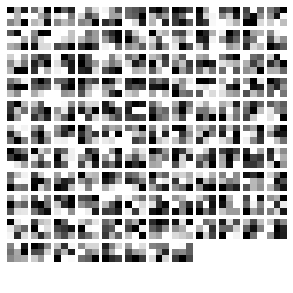

In [91]:
visualize.plot_conv_weights(net.layers_['conv1'], figsize=(5, 5))
pylab.savefig('fig_weights')

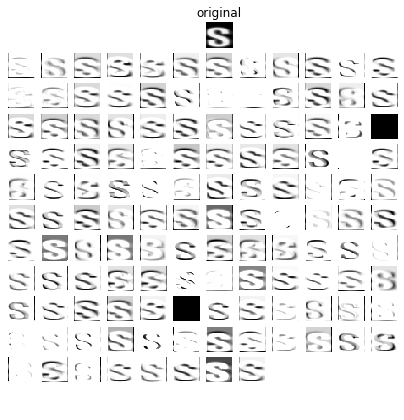

In [93]:
visualize.plot_conv_activity(net.layers_['conv1'], data_train_x[0, ...].reshape((1, 1, 32, 32)), figsize=(7, 7))
pylab.savefig('fig_activity')

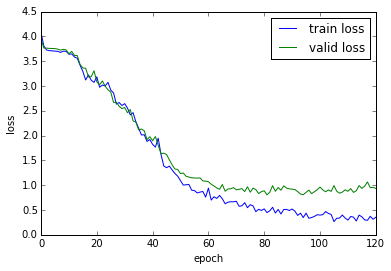

In [119]:
visualize.plot_loss(net)
pylab.savefig('fig_loss')

In [114]:
acc_plt = []
for i in range(len(net.train_history_)):
    acc_plt.append(net.train_history_[i]['valid_accuracy']*100)

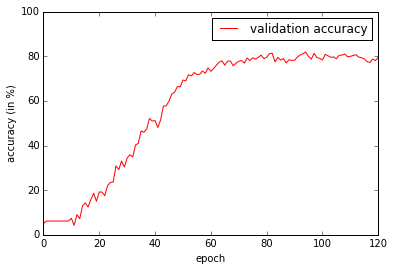

In [120]:
pylab.plot(acc_plt, 'r')
pylab.xlabel('epoch')
pylab.ylabel('accuracy (in %)')
pylab.ylim(0, 100)
pylab.legend(['validation accuracy'])
pylab.savefig('fig_accuracy')